In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

### Read Data

In [3]:
data_path = '../Data/Electric_Consumption.csv'
df=pd.read_csv(data_path)

print(df.shape)
df.head()

(521035, 27)


,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600.0,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600.0,5598.34,216.0,2808.0,5323.20


In [ ]:
# check for unique boroughs
df['Borough'].value_counts()

Borough
BROOKLYN                    199850
MANHATTAN                   132830
BRONX                       118522
QUEENS                       60547
STATEN ISLAND                 3909
NON DEVELOPMENT FACILITY      3441
FHA                           1936
Name: count, dtype: int64

In [5]:
# convert to datetime & rename
df['Service Start Date'] = pd.to_datetime(df['Service Start Date'])
df['ds'] = pd.to_datetime(df['Service End Date'])
df['y'] = df['Consumption (KWH)']


In [ ]:
# take only 5 main boroughs
boroughs = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
monthly_dict = {}
yearly_dict = {}

for i in boroughs:
    # seprate by Borough
    temp_df = df[df['Borough'] == i]
    temp_df = temp_df[['ds', 'y']]
    temp_df.set_index('ds', inplace=True)

    # resample to monthly
    monthly_df = temp_df.resample('M').mean()
    monthly_df = monthly_df[:-1] # remove 2025
    monthly_df.index.freq = pd.infer_freq(monthly_df.index)
    monthly_df = monthly_df.reset_index()
    monthly_dict[i] = monthly_df

    # resample to yearly
    yearly_df = temp_df.resample('YE').mean()
    yearly_df = yearly_df[:-1] # remove 2025
    yearly_df.index.freq = pd.infer_freq(yearly_df.index)
    yearly_df = yearly_df.reset_index()
    yearly_dict[i] = yearly_df

# EDA
1. Electricity consumption for each borough - monthly
2. Electricity consumption for each borough - yearly
3. Seasonal decomposition - monthly
4. Seasonal plot - average consumption by each month of the year to compare boroughs' behavior

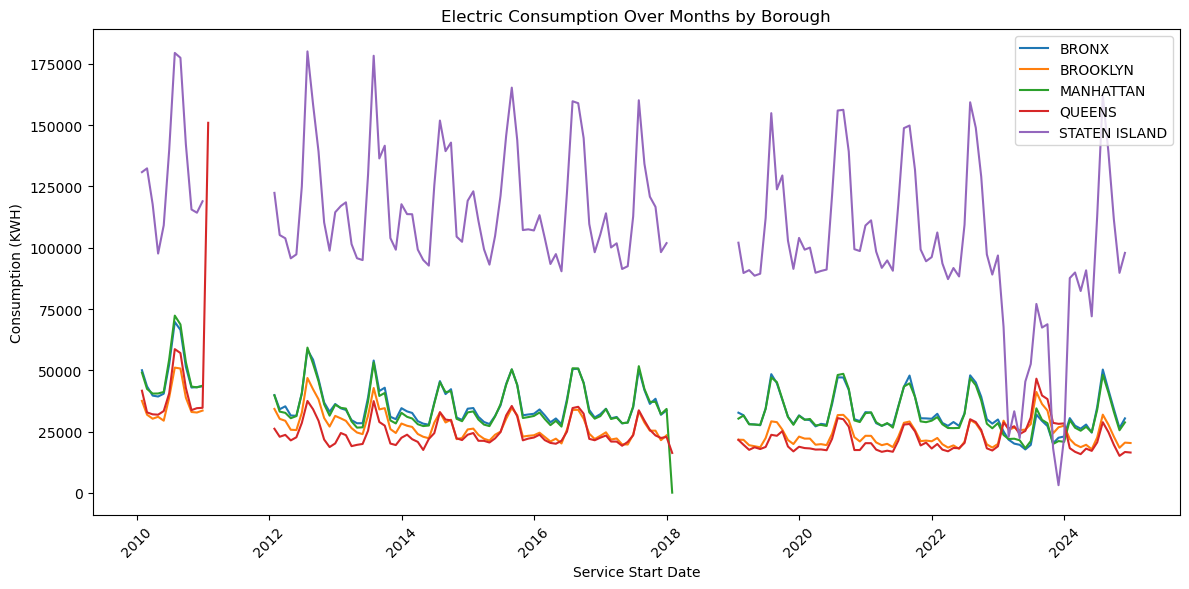

In [10]:
# plot boroughs consumption over months
plt.figure(figsize=(12, 6))
plt.ylabel('Consumption (KWH)')
plt.xlabel('Service Start Date')
plt.title('Electric Consumption Over Months by Borough')

for b in monthly_dict.keys():
    plt.plot(monthly_dict[b]['ds'], monthly_dict[b]['y'], label=b)

# for i in df['Borough'].value_counts().index:
#     plt.plot(globals()[f"df_monthly_{i}"]['ds'], globals()[f"df_monthly_{i}"]['y'], label=i)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

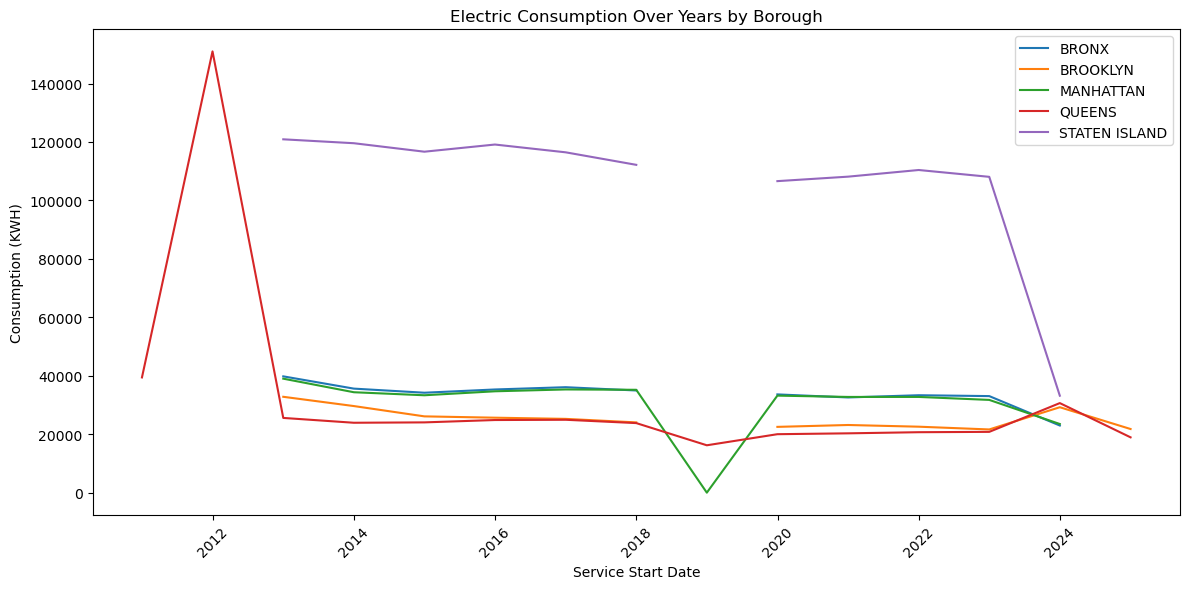

In [11]:
# plot boroughs consumption over years
plt.figure(figsize=(12, 6))
plt.ylabel('Consumption (KWH)')
plt.xlabel('Service Start Date')
plt.title('Electric Consumption Over Years by Borough')

for b in yearly_dict.keys():
    plt.plot(yearly_dict[b]['ds'], yearly_dict[b]['y'], label=b)

# for i in df['Borough'].value_counts().index:
#     plt.plot(globals()[f"df_yearly_{i}"]['ds'], globals()[f"df_yearly_{i}"]['y'], label=i)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

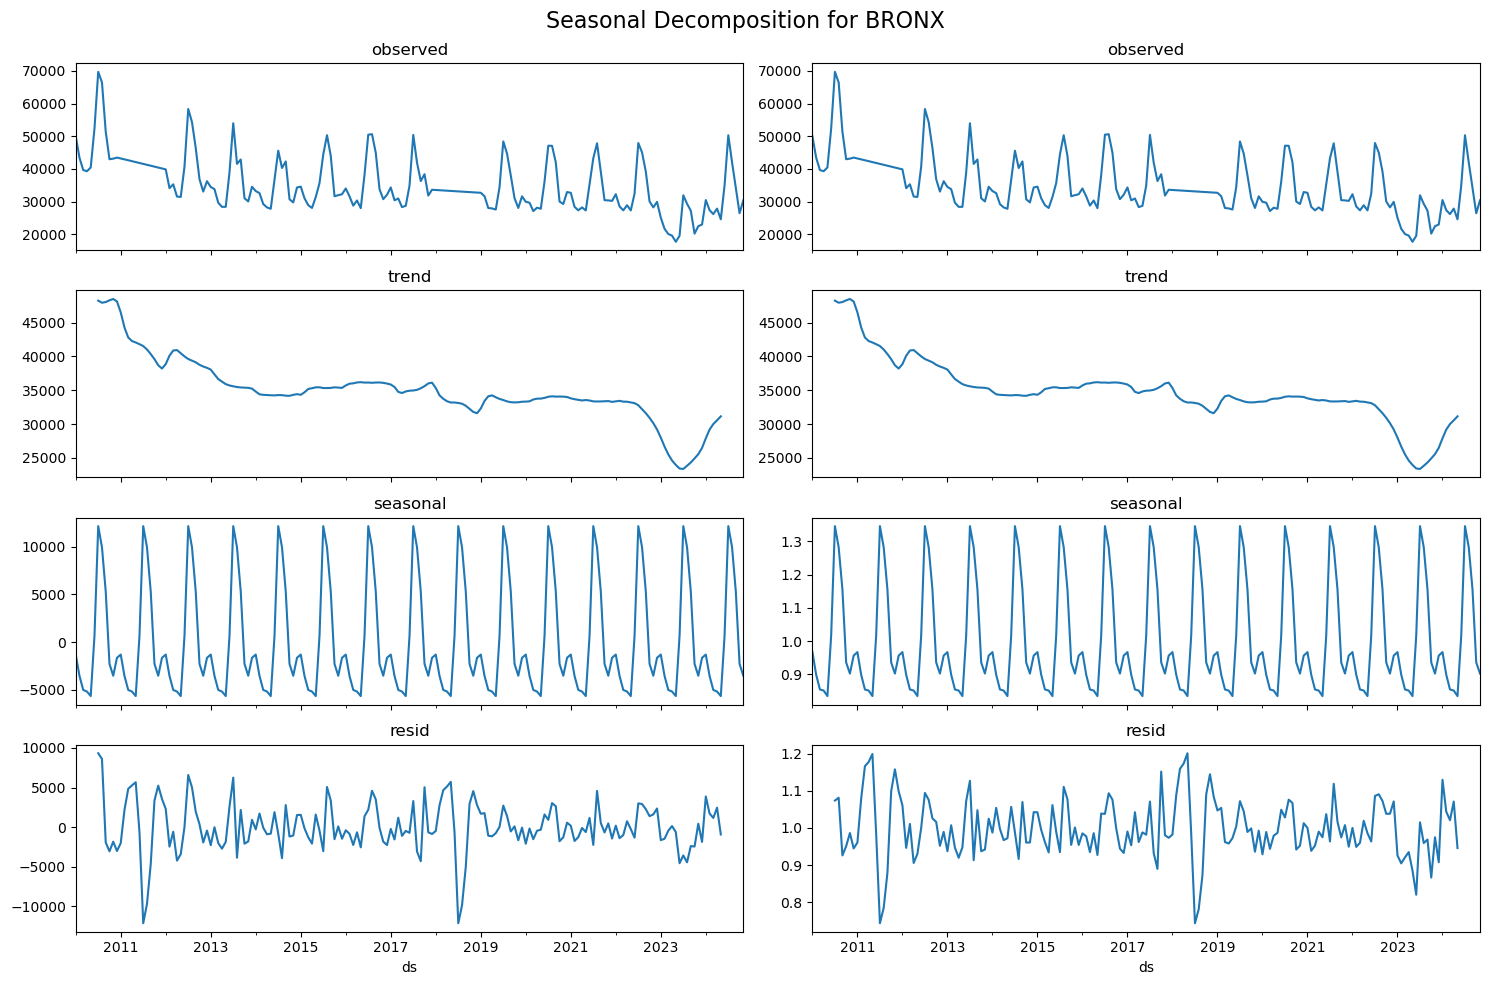

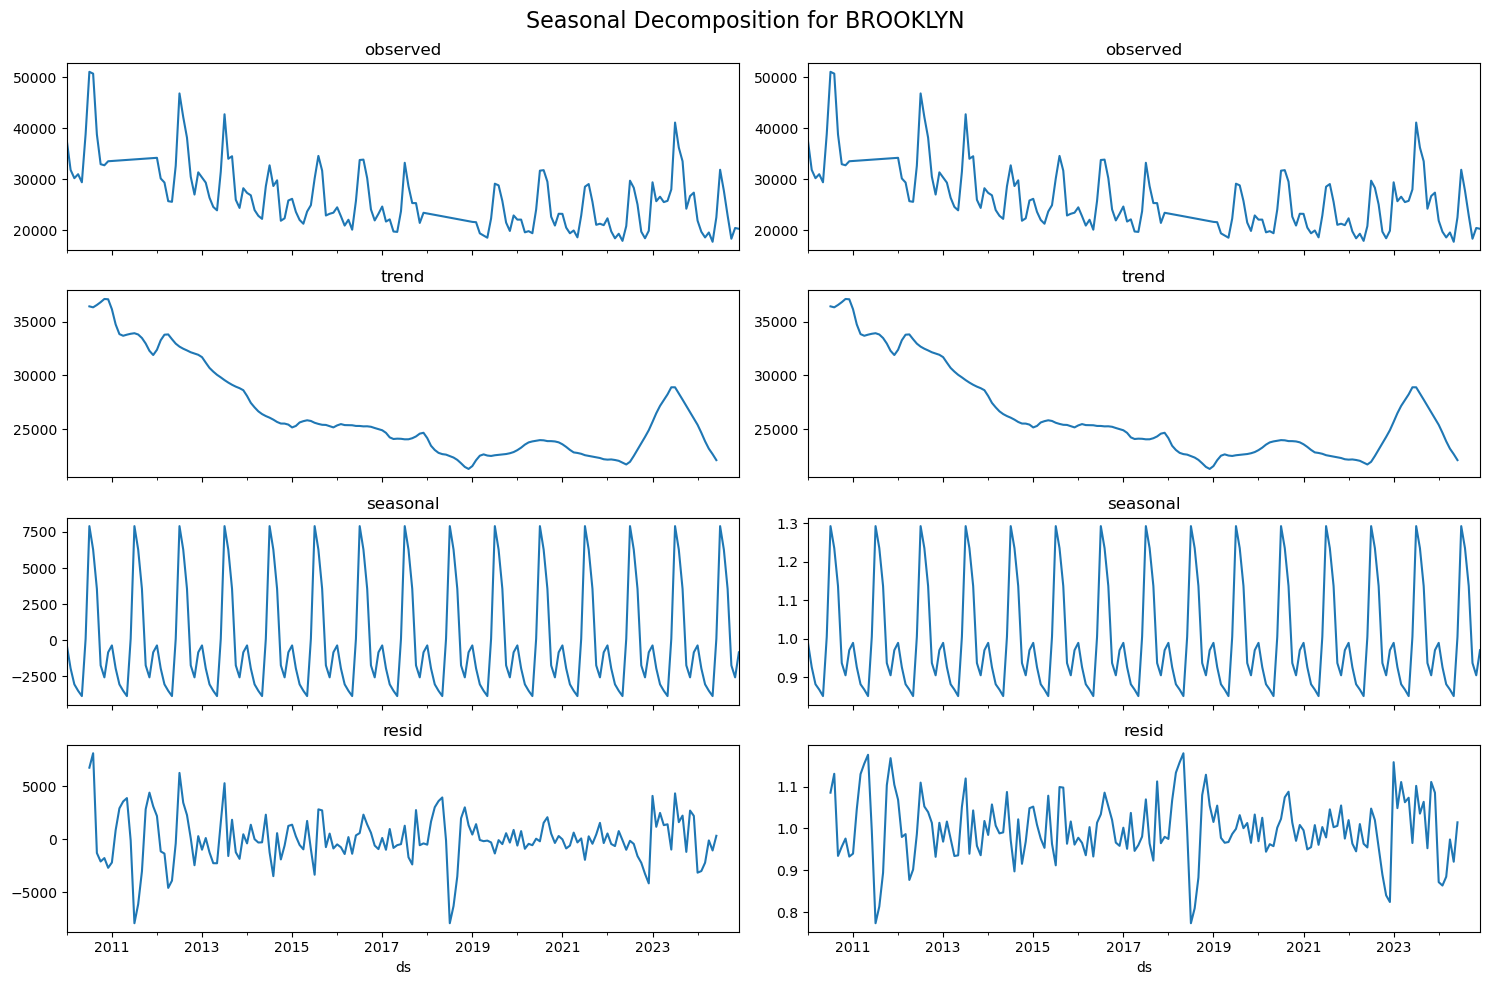

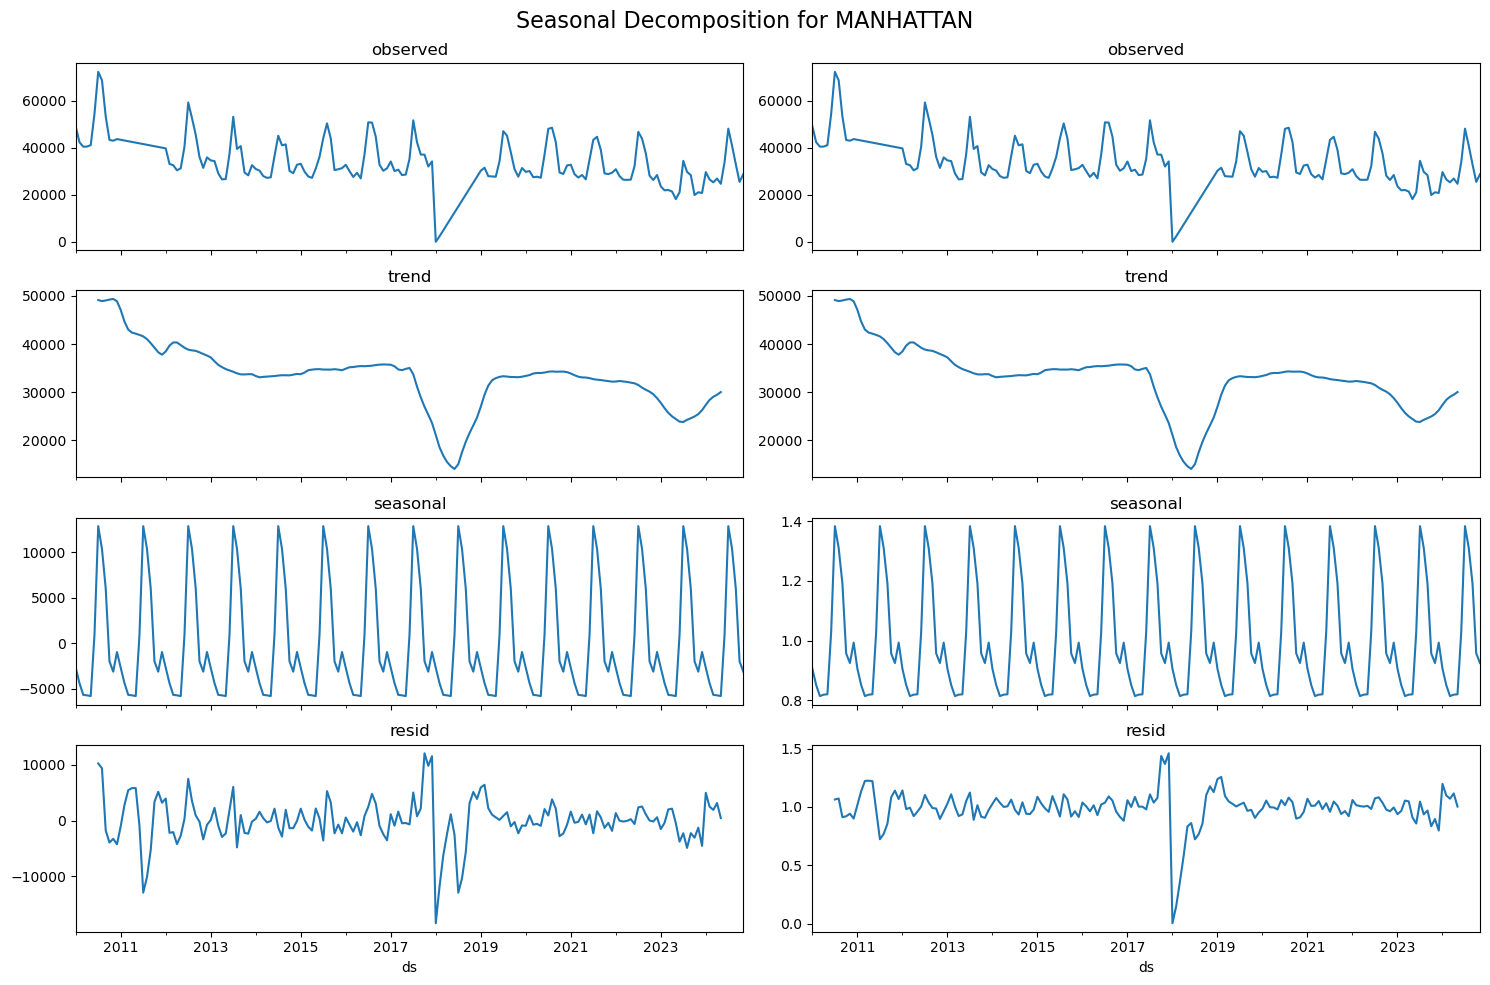

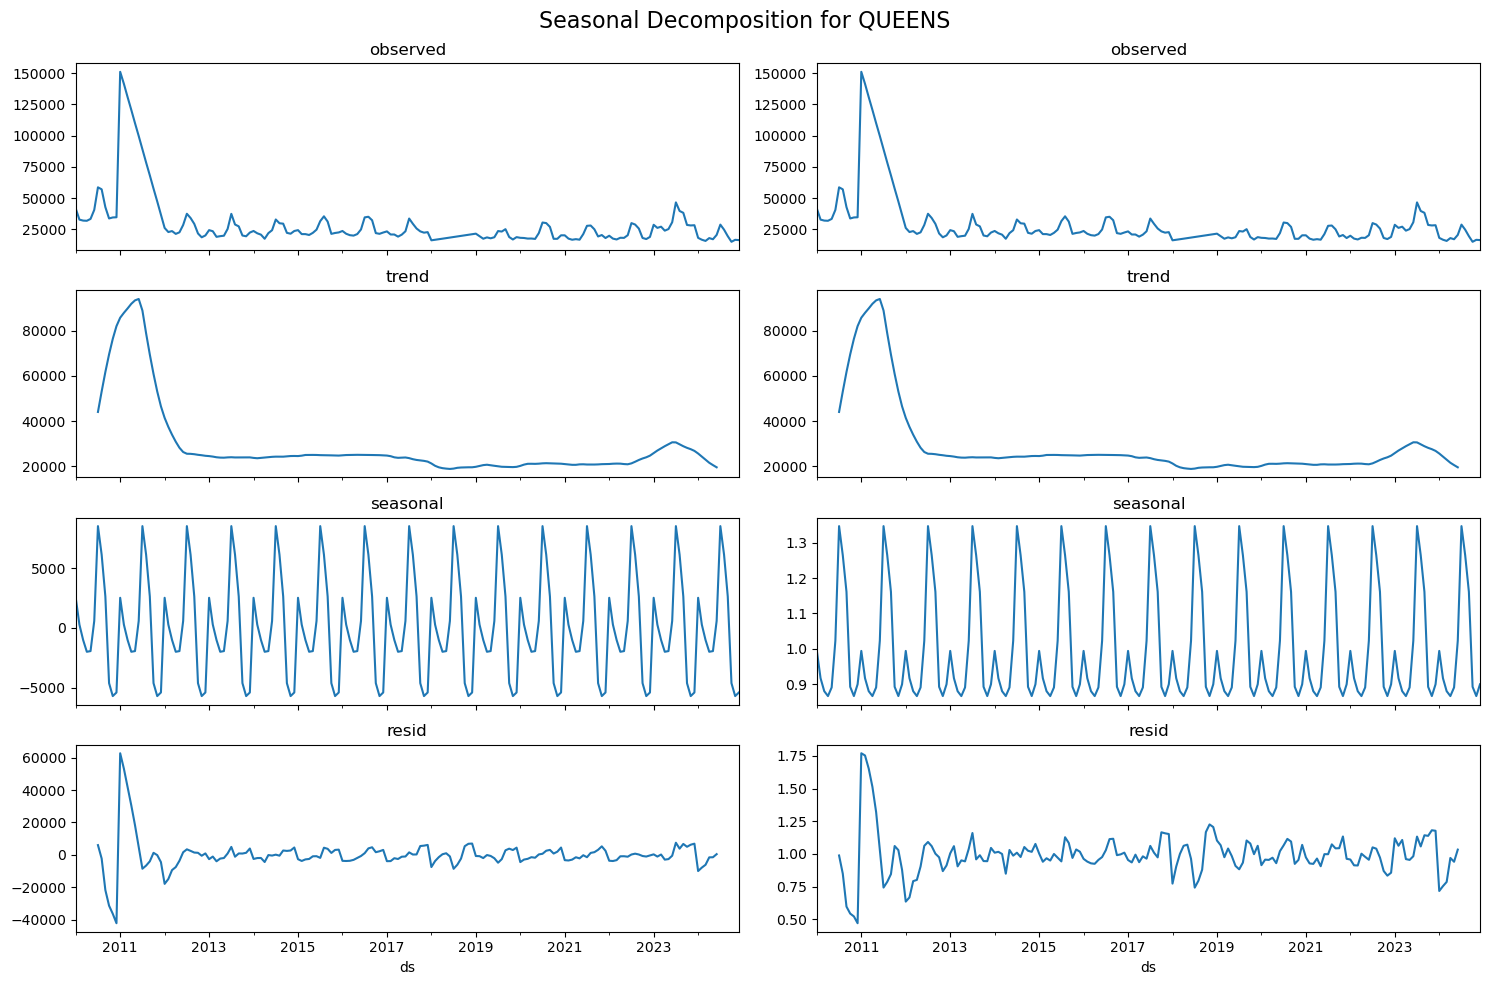

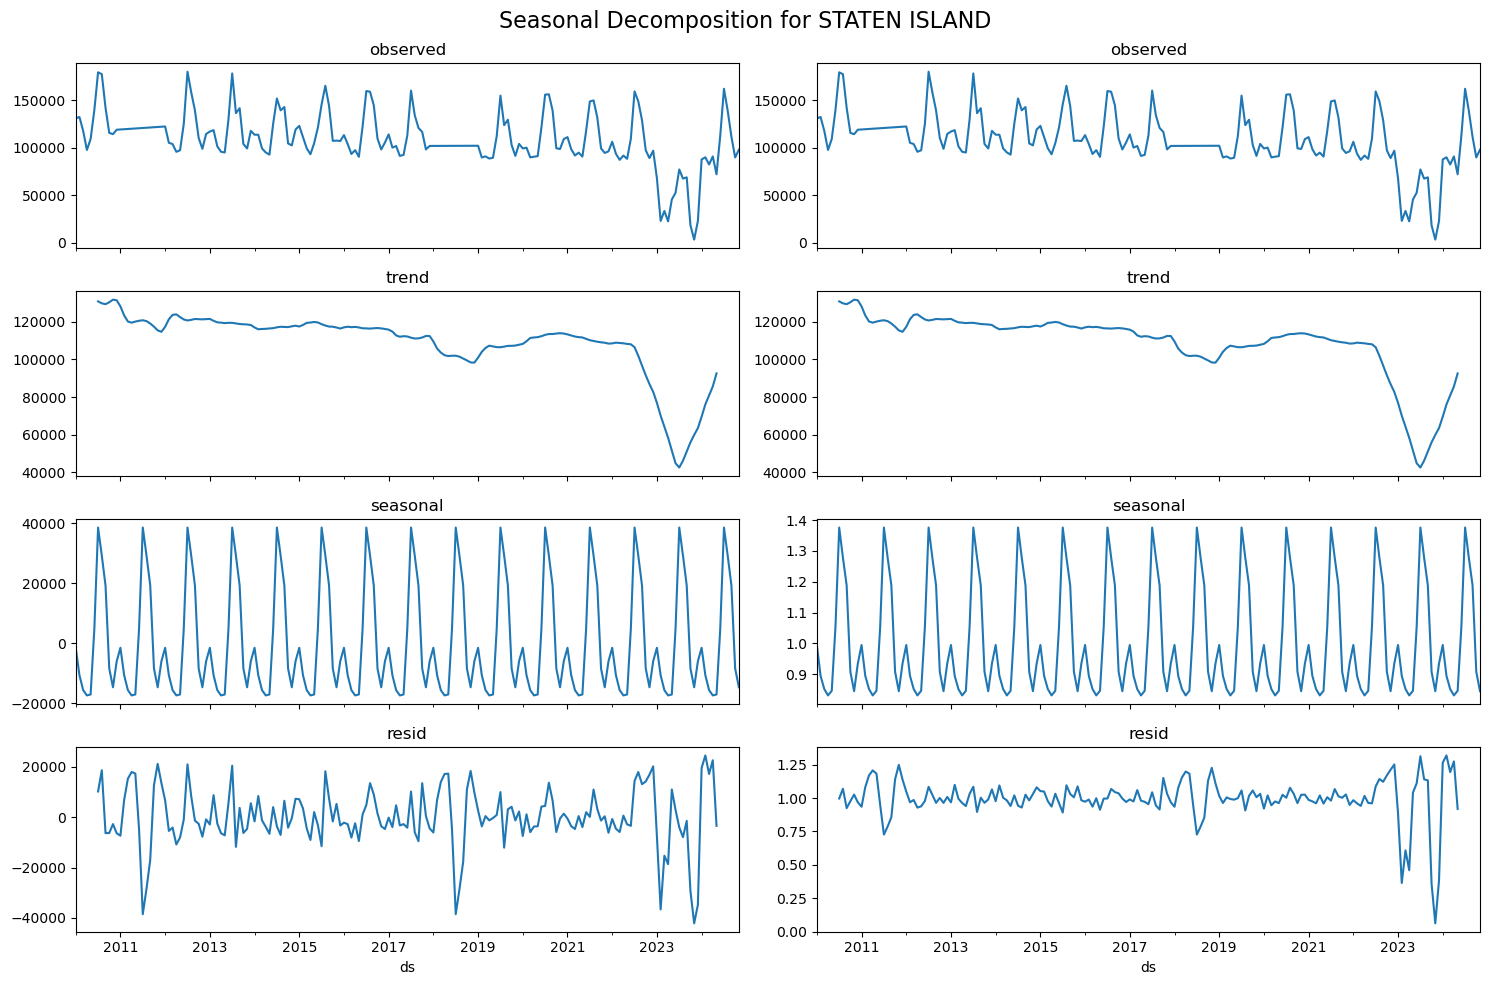

In [13]:
# seasonal decomposition
for b in monthly_dict.keys():
    df = monthly_dict[b].copy()
    df.set_index('ds', inplace=True)
    df['y'] = df['y'].interpolate(method='time')

    result_add = seasonal_decompose(df['y'], model='additive', period=12)
    result_mult = seasonal_decompose(df['y'], model='multiplicative', period=12)

    fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)
    fig.suptitle(f"Seasonal Decomposition for {b}", fontsize=16)

    # additive decomposition
    components = ['observed', 'trend', 'seasonal', 'resid']
    for j, comp in enumerate(components):
        result_add.__getattribute__(comp).plot(ax=axes[j, 0], legend=False)
        axes[j, 0].set_title(comp)

    # multiplicative decomposition
    components = ['observed', 'trend', 'seasonal', 'resid']
    for j, comp in enumerate(components):
        result_mult.__getattribute__(comp).plot(ax=axes[j, 1], legend=False)
        axes[j, 1].set_title(comp)

    plt.tight_layout()
    plt.show()

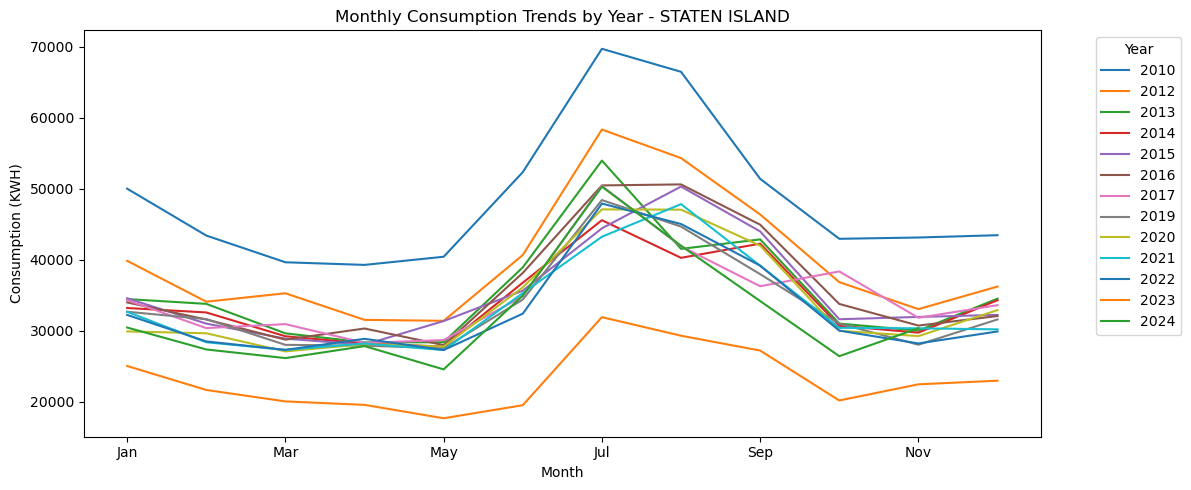

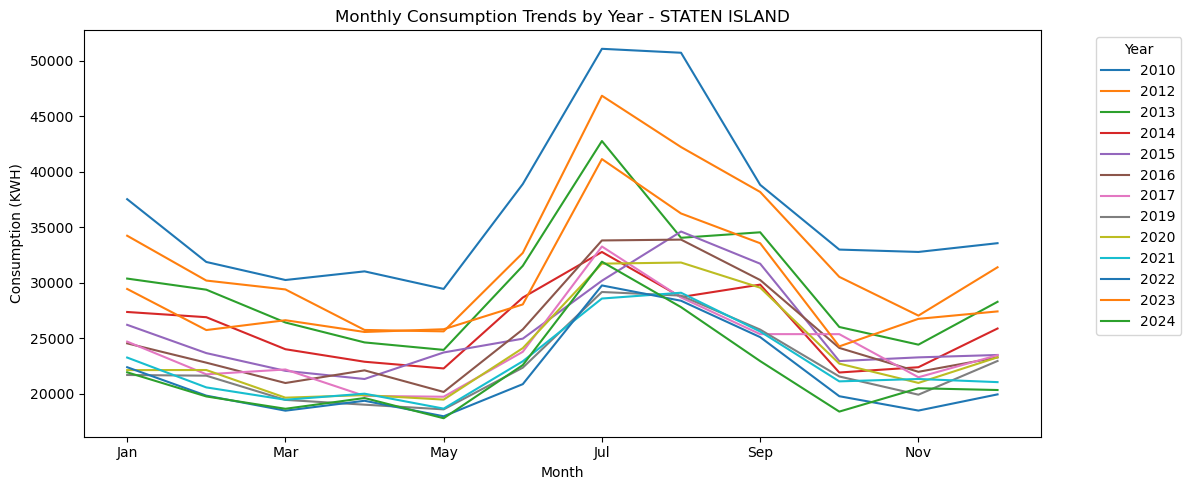

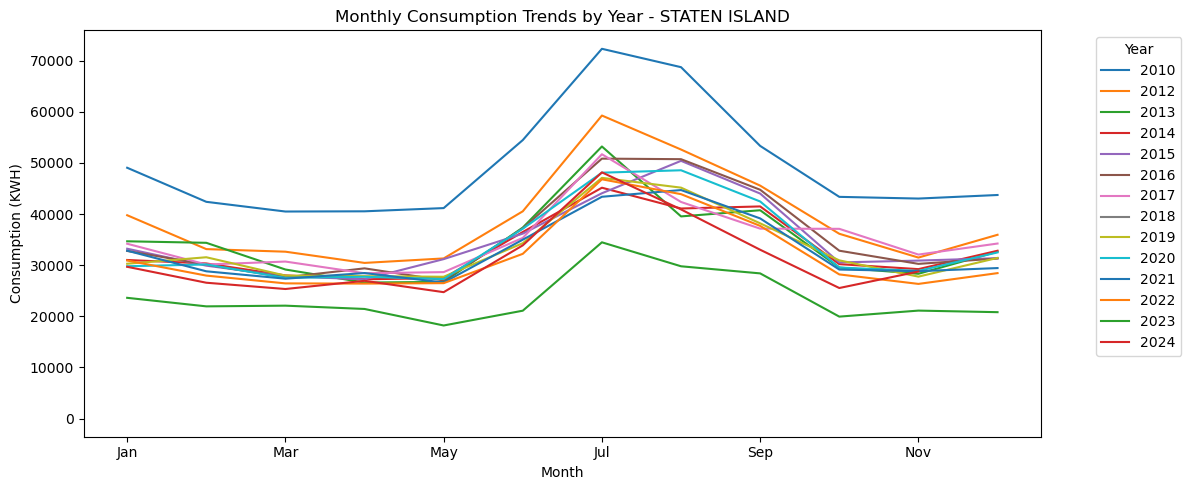

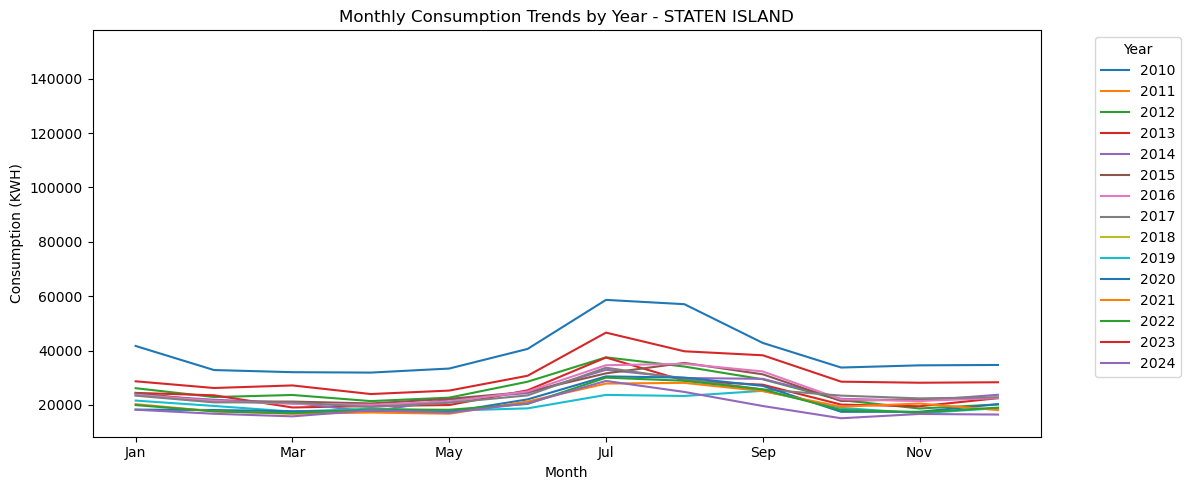

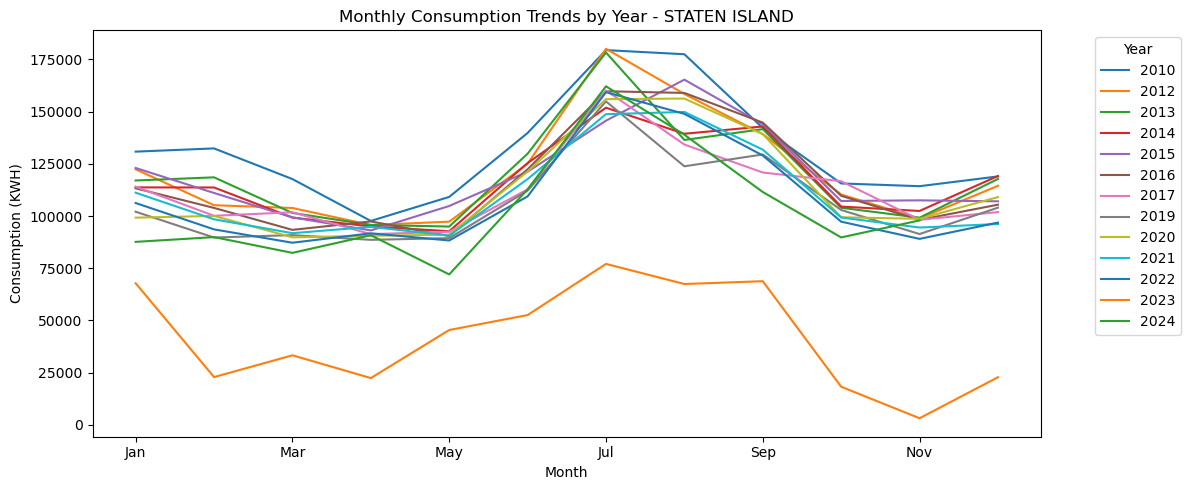

In [16]:
# seasonality by boroughs
for b in monthly_dict.keys():
    seasonality_plot_df = monthly_dict[b].copy()
    seasonality_plot_df.set_index('ds', inplace=True)

    # Extract year and month
    seasonality_plot_df['year'] = seasonality_plot_df.index.year
    seasonality_plot_df['month'] = seasonality_plot_df.index.month

    # Pivot: rows = month, cols = year, values = y
    pivot = seasonality_plot_df.pivot_table(index='month', columns='year', values='y')

    # Rename month index
    pivot.index = pivot.index.map(lambda x: calendar.month_abbr[x])

    # Plot
    pivot.plot(figsize=(12, 5), title=f'Monthly Consumption Trends by Year - {i}')
    plt.ylabel("Consumption (KWH)")
    plt.xlabel("Month")
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Prediction

## Monthly

21:15:01 - cmdstanpy - INFO - Chain [1] start processing
21:15:01 - cmdstanpy - INFO - Chain [1] done processing
21:15:01 - cmdstanpy - INFO - Chain [1] start processing
21:15:01 - cmdstanpy - INFO - Chain [1] done processing


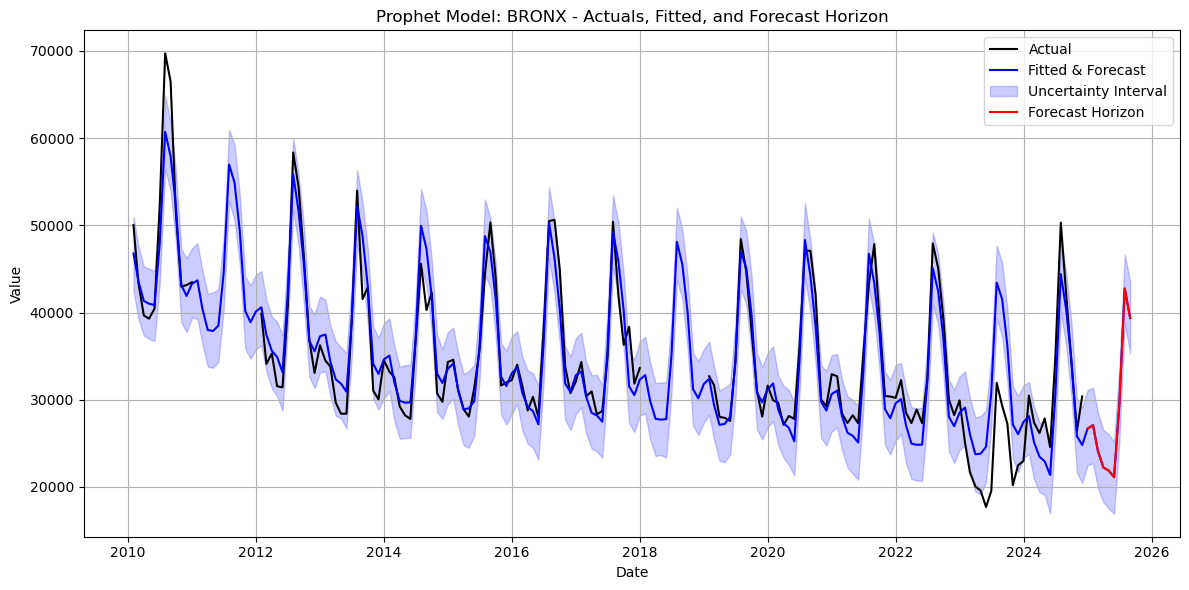

21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:02 - cmdstanpy - INFO - Chain [1] done processing
21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing


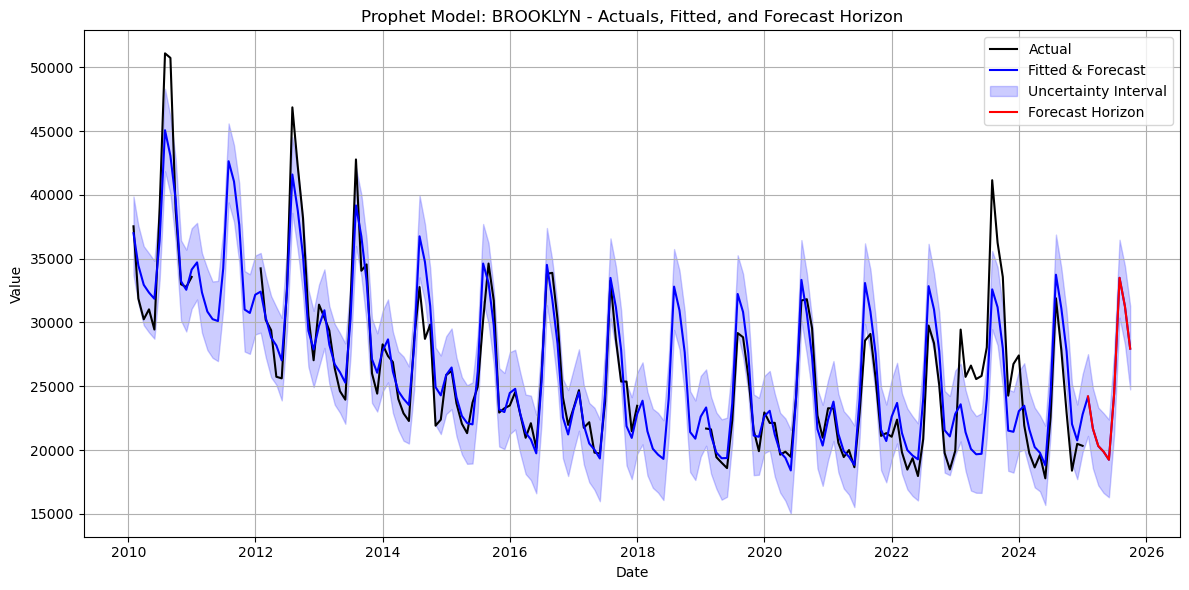

21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:04 - cmdstanpy - INFO - Chain [1] start processing
21:15:04 - cmdstanpy - INFO - Chain [1] done processing


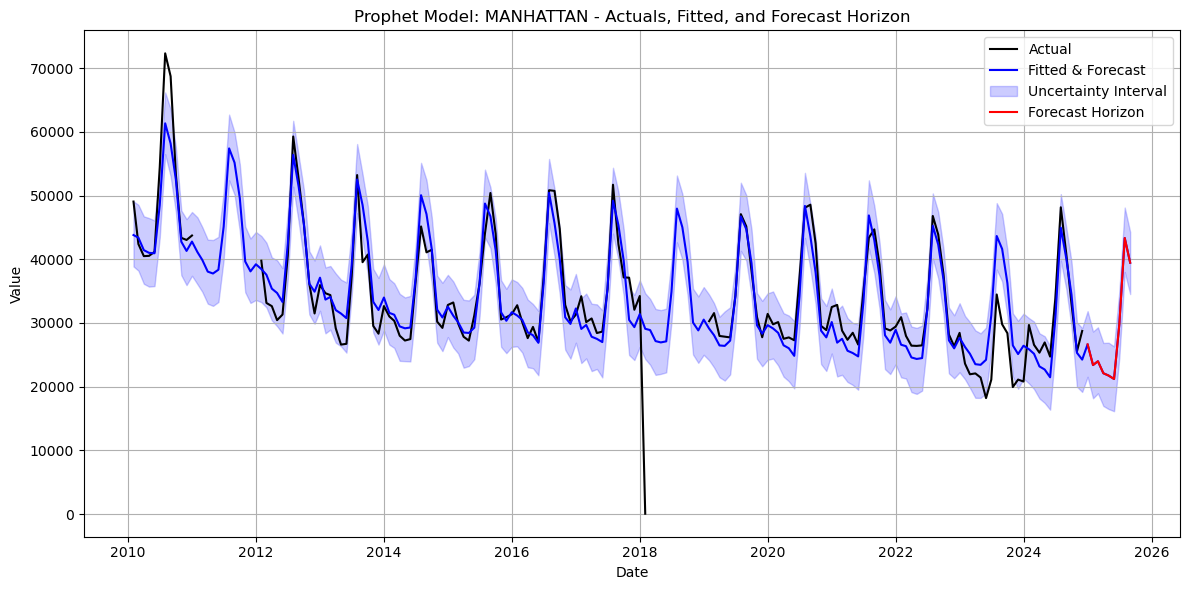

21:15:04 - cmdstanpy - INFO - Chain [1] start processing
21:15:04 - cmdstanpy - INFO - Chain [1] done processing
21:15:05 - cmdstanpy - INFO - Chain [1] start processing
21:15:05 - cmdstanpy - INFO - Chain [1] done processing


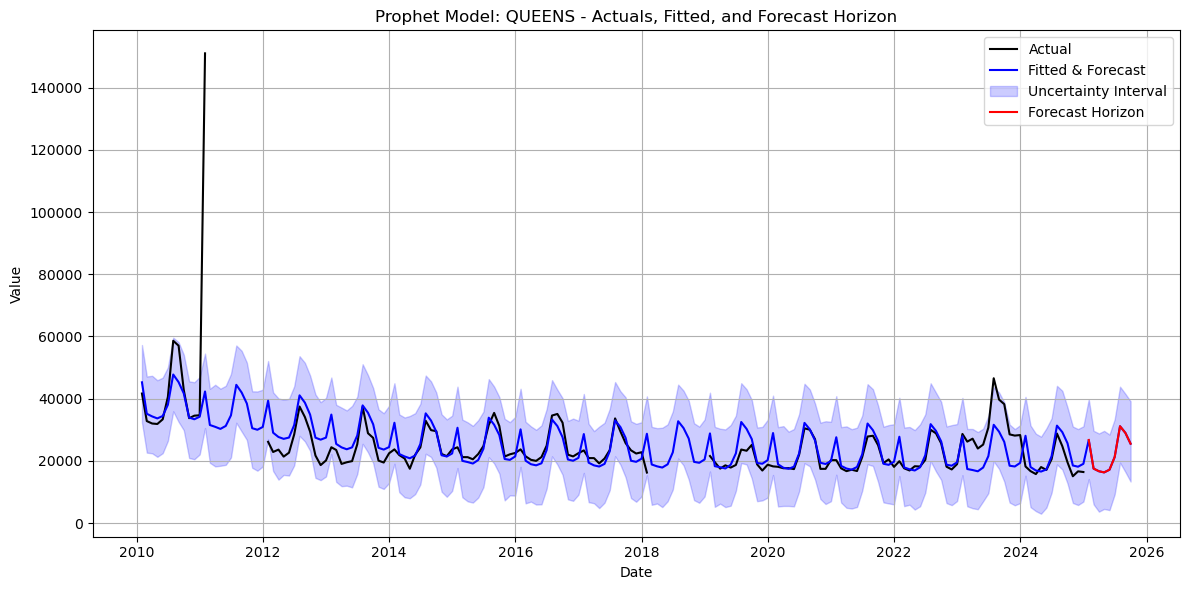

21:15:05 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing


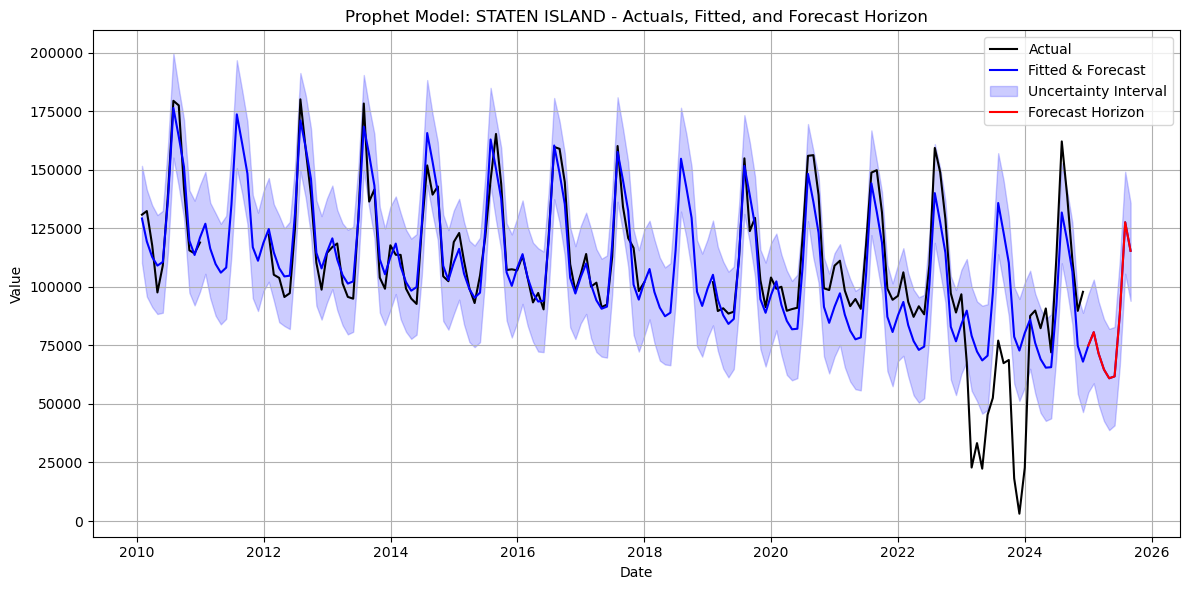


Model Performance Summary by Borough:
         Borough       MAE  MAPE   R^2
0          BRONX   4901.62  0.18  0.20
1       BROOKLYN   4740.39  0.20 -0.41
2      MANHATTAN   3318.02  0.12  0.66
3         QUEENS  11550.48  0.52 -3.13
4  STATEN ISLAND  17328.81  0.85  0.33


In [ ]:
# init metrics collection list
metrics_summary = []

# iterate through each borough in the dictionary
for b in monthly_dict.keys():
    df = monthly_dict[b].copy().reset_index(drop=True)

    # ensure datetime format for the 'ds' column
    df['ds'] = pd.to_datetime(df['ds'])

    # filter to keep only rows with end-of-month dates
    df = df[df['ds'].dt.is_month_end].reset_index(drop=True)

    # split data into training (until end of 2018) and testing (2020-2024)
    train_df = df[df['ds'] <= '2018-12-31']
    test_df = df[df['ds'] >= '2020-01-31']

    ########### train model on training set and evaluate on test set ###########
    model = Prophet()
    model.fit(train_df)

    # make predictions over the test period (ending at end of dataset)
    test_future = model.make_future_dataframe(periods=(df['ds'].max() - train_df['ds'].max()).days // 30, freq='M')
    test_forecast = model.predict(test_future)

    merged_test = pd.merge(test_forecast[['ds', 'yhat']], test_df, on='ds', how='inner')

    # compute evaluation metrics
    mae = mean_absolute_error(merged_test['y'], merged_test['yhat'])
    mape = mean_absolute_percentage_error(merged_test['y'], merged_test['yhat'])
    r2 = r2_score(merged_test['y'], merged_test['yhat'])

    # store metrics
    metrics_summary.append({
        'Borough': b,
        'MAE': mae,
        'MAPE': mape,
        'R^2': r2
    })

    ########### fit the model again on the entire dataset ###########
    final_model = Prophet()
    final_model.fit(df)

    # make prediction for 9-month forecast horizon
    forecast_horizon = 9
    final_future = final_model.make_future_dataframe(periods=forecast_horizon, freq='M')
    final_forecast = final_model.predict(final_future)

    # merge with actuals to support plotting
    merged_all = pd.merge(final_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], df, on='ds', how='left')
    merged_all.set_index('ds', inplace=True)

    # create forecast horizon mask from final date in df
    forecast_start = df['ds'].max() + pd.offsets.MonthEnd(1)
    forecast_end = forecast_start + pd.offsets.MonthEnd(forecast_horizon - 1)
    forecast_mask = (merged_all.index >= forecast_start) & (merged_all.index <= forecast_end)

    plt.figure(figsize=(12, 6))

    # actuals
    plt.plot(merged_all.index, merged_all['y'], label='Actual', color='black')

    # predictions for entire historical period
    plt.plot(merged_all.index, merged_all['yhat'], label='Fitted & Forecast', color='blue')

    # fill uncertainty interval
    plt.fill_between(merged_all.index, merged_all['yhat_lower'], merged_all['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

    # forecast horizon highlighted in red
    plt.plot(merged_all.index[forecast_mask], merged_all['yhat'][forecast_mask], label='Forecast Horizon', color='red')

    plt.title(f'Borough: {b} - Monthly Predictions for Next {forecast_horizon} Months')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# create and display summary dataframe
metrics_df = pd.DataFrame(metrics_summary)
print("\nModel Performance Summary by Borough:")
print(metrics_df.round(2))


## Yearly

21:30:31 - cmdstanpy - INFO - Chain [1] start processing
21:30:31 - cmdstanpy - INFO - Chain [1] done processing
21:30:31 - cmdstanpy - INFO - Chain [1] start processing
21:30:31 - cmdstanpy - INFO - Chain [1] done processing


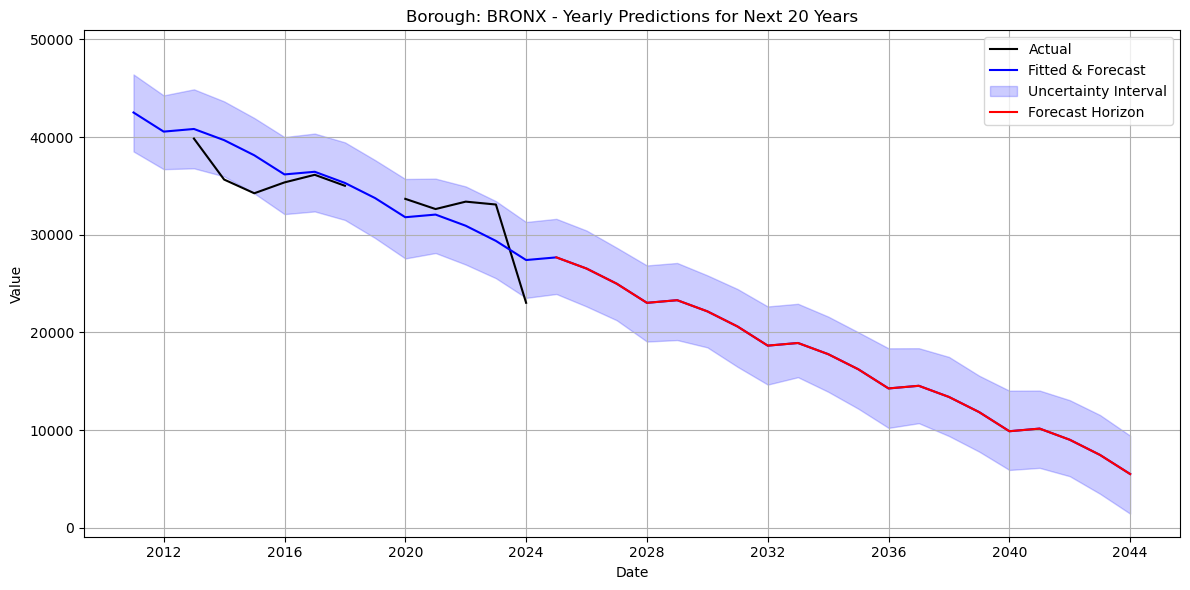

21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing


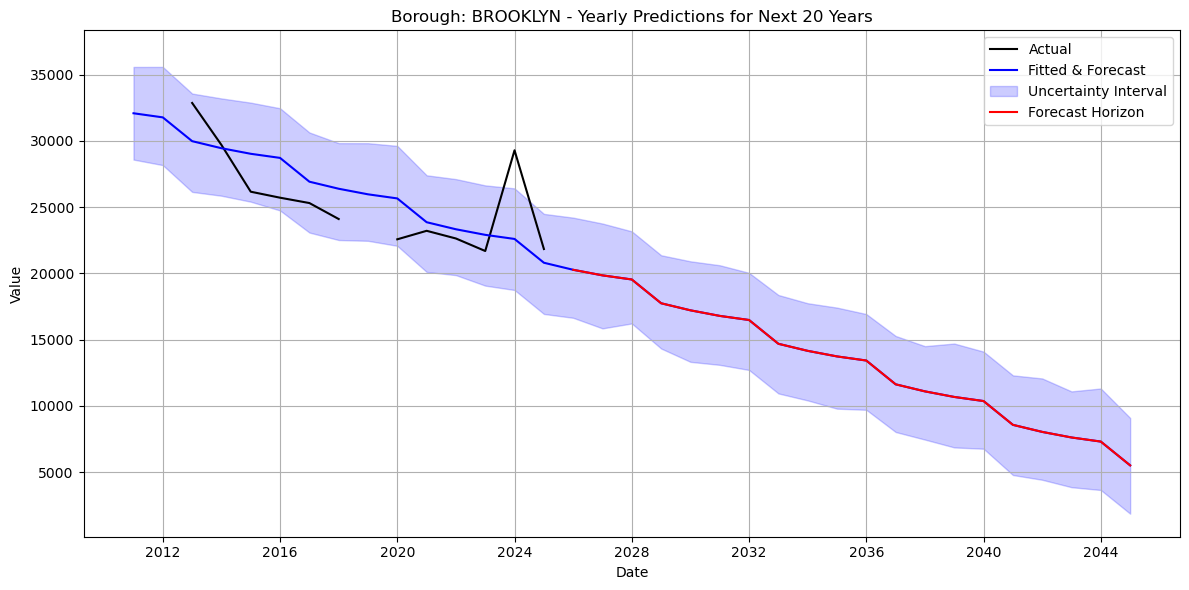

21:30:33 - cmdstanpy - INFO - Chain [1] start processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing


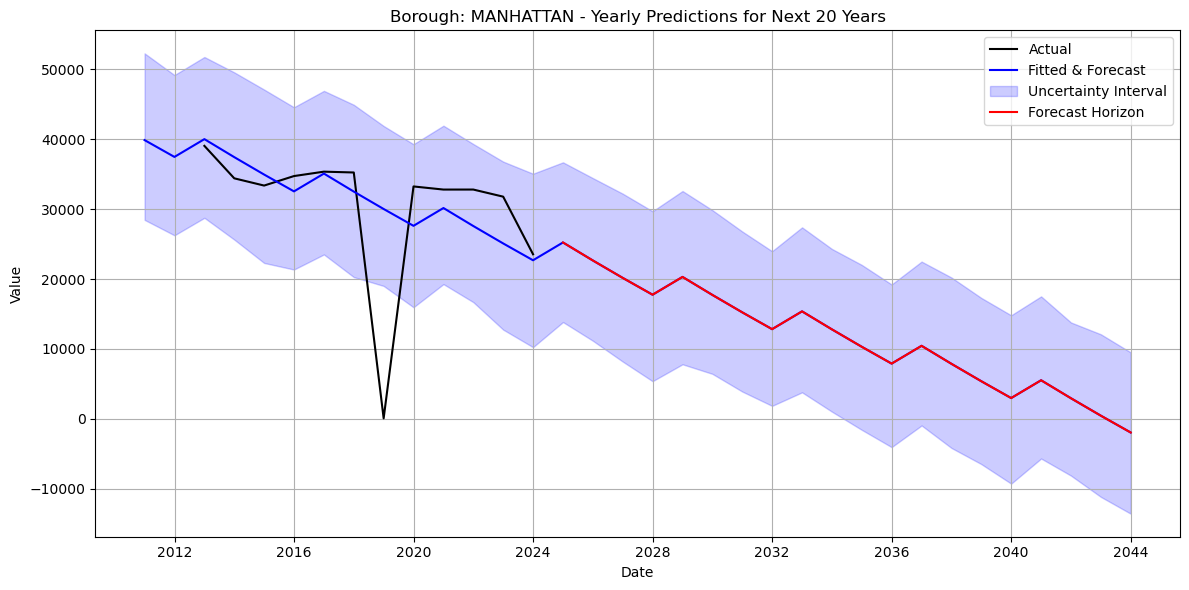

21:30:34 - cmdstanpy - INFO - Chain [1] start processing
21:30:34 - cmdstanpy - INFO - Chain [1] done processing
21:30:34 - cmdstanpy - INFO - Chain [1] start processing
21:30:34 - cmdstanpy - INFO - Chain [1] done processing


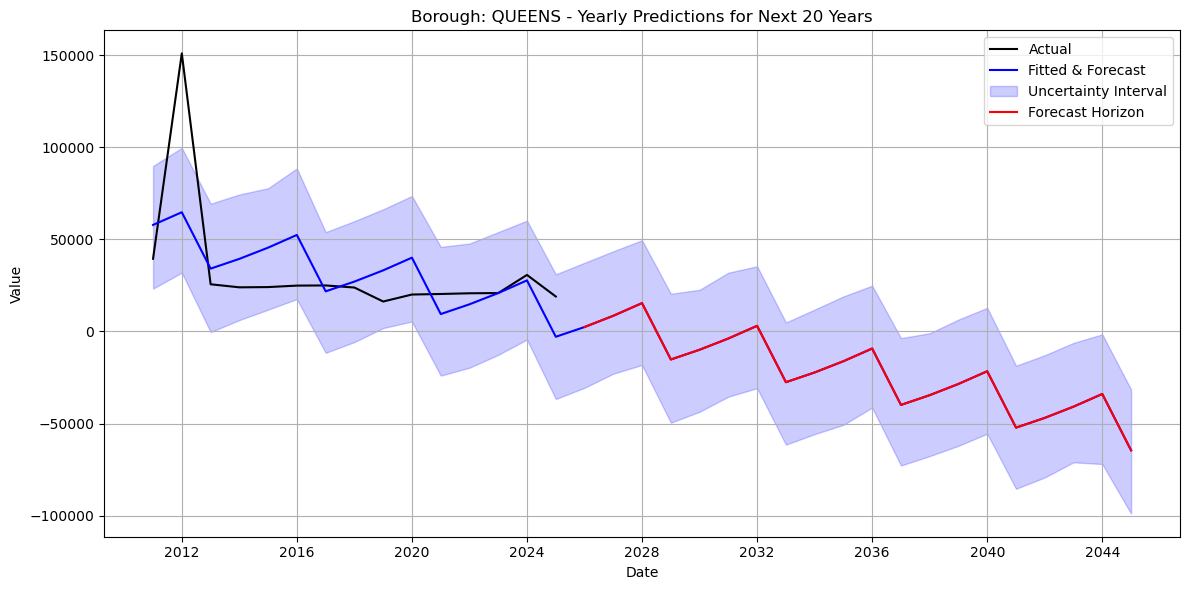

21:30:34 - cmdstanpy - INFO - Chain [1] start processing
21:30:34 - cmdstanpy - INFO - Chain [1] done processing
21:30:35 - cmdstanpy - INFO - Chain [1] start processing
21:30:35 - cmdstanpy - INFO - Chain [1] done processing


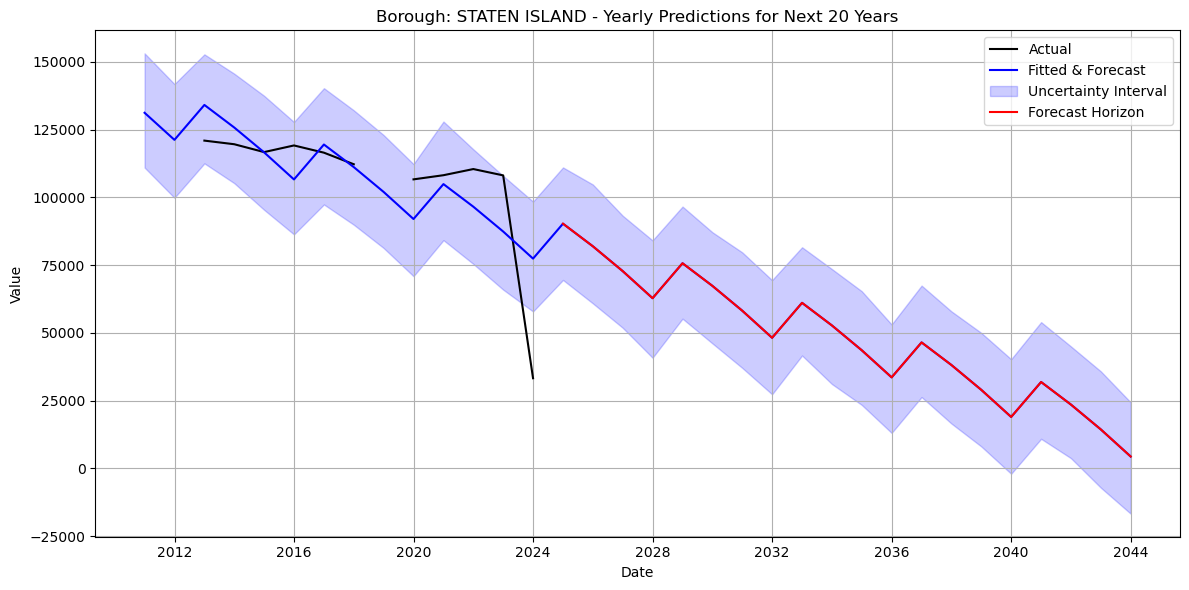


Model Performance Summary by Borough:
         Borough       MAE  MAPE    R^2
0          BRONX   4448.44  0.17   0.14
1       BROOKLYN   6458.97  0.25  -3.67
2      MANHATTAN   7691.95  0.27  -2.85
3         QUEENS  20669.67  0.98 -20.64
4  STATEN ISLAND  36037.29  1.05  -0.70


In [ ]:
# init metrics collection list
metrics_summary = []

# iterate through each borough in the dictionary
for b in yearly_dict.keys():
    df = yearly_dict[b].copy().reset_index(drop=True)

    # split data into training (until end of 2021) and testing (2022-2024)
    train_df = df[df['ds'] <= '2021-12-31']
    test_df = df[(df['ds'] >= '2022-01-01') & (df['ds'] <= '2024-12-31')]

    ########### train model on training set and evaluate on test set ###########
    model = Prophet()
    model.fit(train_df)

    # make predictions over the test period (3 years)
    test_future = model.make_future_dataframe(periods=3, freq='Y')
    test_forecast = model.predict(test_future)

    merged_test = pd.merge(test_forecast[['ds', 'yhat']], test_df, on='ds', how='inner')

    # compute evaluation metrics
    mae = mean_absolute_error(merged_test['y'], merged_test['yhat'])
    mape = mean_absolute_percentage_error(merged_test['y'], merged_test['yhat'])
    r2 = r2_score(merged_test['y'], merged_test['yhat'])

    # store metrics
    metrics_summary.append({
        'Borough': b,
        'MAE': mae,
        'MAPE': mape,
        'R^2': r2
    })

    ########### fit the model again on the entire dataset ###########
    final_model = Prophet()
    final_model.fit(df)

    # make prediction for 20-year forecast horizon
    forecast_horizon = 20
    final_future = final_model.make_future_dataframe(periods=forecast_horizon, freq='Y')
    final_forecast = final_model.predict(final_future)

    # merge with actuals for plotting
    merged_all = pd.merge(final_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], df, on='ds', how='left')
    merged_all.set_index('ds', inplace=True)

    # create forecast horizon mask from final date in df
    forecast_start = df['ds'].max() + pd.offsets.YearEnd(1)
    forecast_end = forecast_start + pd.offsets.YearEnd(forecast_horizon - 1)
    forecast_mask = (merged_all.index >= forecast_start) & (merged_all.index <= forecast_end)

    plt.figure(figsize=(12, 6))

    # actuals
    plt.plot(merged_all.index, merged_all['y'], label='Actual', color='black')

    # predictions for entire historical period
    plt.plot(merged_all.index, merged_all['yhat'], label='Fitted & Forecast', color='blue')

    # fill uncertainty interval
    plt.fill_between(merged_all.index, merged_all['yhat_lower'], merged_all['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

    # forecast horizon highlighted in red
    plt.plot(merged_all.index[forecast_mask], merged_all['yhat'][forecast_mask], label='Forecast Horizon', color='red')

    plt.title(f'Borough: {b} - Yearly Predictions for Next {forecast_horizon} Years')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# create and display summary dataframe
metrics_df = pd.DataFrame(metrics_summary)
print("\nModel Performance Summary by Borough:")
print(metrics_df.round(2))


### Interpertations:
* Our model performs reasonably only for the BRONX.
* For other boroughs, especially QUEENS and STATEN ISLAND, the performance is poor. Several reasons:
    - Small sample size (only 15 training points),
    - High variance or anomalies,
    - Prophet struggling to capture long-term trends with such limited data.